<a href="https://colab.research.google.com/github/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Feature_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [908 kB]
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get

'/usr/local/lib/python3.10/dist-packages/pyspark'

## Loading Libraries

In [2]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing datetime library
from datetime import datetime, timedelta

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing userdata from Google Colab Library
from google.colab import userdata

# Importing Tensorflow and Tensorflow layers
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import ModelCheckpoint

# Importing Keras
import keras

# Importing LightGBM library
import lightgbm as lgb

# Importing hyperopt
from hyperopt import hp, fmin, tpe, Trials

# Importing pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
import pyspark.sql.functions as f
from pyspark.sql.window import Window

# Importing stats module from scipy
from scipy import stats

# Importing classification evaluation metrics from Sklearn
from sklearn.metrics import roc_auc_score, f1_score

# Creating a spark session
spark = SparkSession.builder.appName("FeatureAnalysis").getOrCreate()

spark

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


## Read Data

The following cell reads the customer lifetime value data from Google Drive and converts it to a pandas dataframe for feature analysis. For more details about how the customer lifetime value dataframe was created please see notebook "Customer_Spend_Model_Feature_Processing.ipynb".

In [39]:
# Defining dataframe path
file_path = "../content/drive/MyDrive/Colab/Sandbox/customer_spend_model"

# Reading customer lifetime value dataframe and creating a pandas table
cltv_tbl = spark.read.parquet(file_path).toPandas()

# Showing the dataframe
cltv_tbl

,cust_id,ref_dt,ref_year,ref_month,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
0,10661662,2013-09-01,2013,9,39.949982,15.830137,16.306849,1,39.949982,15.830137,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
1,10661662,2013-10-01,2013,10,39.949982,16.832877,17.326027,1,39.949982,16.832877,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
2,10661662,2013-11-01,2013,11,39.949982,17.835616,18.312329,1,39.949982,17.835616,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
3,10661662,2013-12-01,2013,12,39.949982,18.838356,19.331507,1,39.949982,18.838356,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
4,10661662,2014-01-01,2014,1,39.949982,19.857534,20.350685,1,39.949982,19.857534,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,11183977,2013-06-01,2013,6,37.399994,3.260274,3.813699,3,136.949970,9.780822,0,1,1,1,0.0,51.899994,47.649982,37.399994,0.0
7540,11183977,2013-07-01,2013,7,37.399994,3.594521,4.832877,3,136.949970,10.783562,0,1,1,1,0.0,51.899994,47.649982,37.399994,0.0
7541,11183977,2013-08-01,2013,8,37.399994,3.934247,5.852055,3,136.949970,11.802740,0,1,1,0,0.0,51.899994,47.649982,0.000000,0.0
7542,11183977,2013-09-01,2013,9,37.399994,4.268493,6.838356,3,136.949970,12.805479,0,0,1,1,0.0,0.000000,51.899994,47.649982,0.0


## Features Description

All information is aggregated at a customer level and month level.

- **cust_id**: Customer id;
- **ref_dt**: The reference date used in calculations that are time dependent like recency and account age;
- **first_trans_amt**: First transaction amount;
- **trans_rate**: The average number of transaction per month;
- **recency**: Number of days between the reference date and the last transaction date;
- **frequency**: Number of months with transactions up to the reference date;
- **monetary**: Total amount spent up to the reference date;
- **lifetime**: Number of days between the reference date and the first transaction date;
- **tran_qnt_R03m_lag0**: The rolling 3 months transaction quantity;
- **tran_qnt_R03m_lag1**: The rolling 3 months transaction quantity lagged by 3 months. When this feature is equal to -1 it means that the customer has less than 3 months of lifetime;
- **tran_qnt_R03m_lag2**: The rolling 3 months transaction quantity lagged by 12 months. When this feature is equal to -1 it means that the customer has less than 12 months of lifetime;
- **trans_qnt_R03m_mov_avg**: The moving average of the rolling 3 months transaction quantity;
- **tran_amt_R03m_lag0**: The rolling 3 months transaction amount;
- **tran_amt_R03m_lag1**: The rolling 3 months transaction amount lagged by 3 months. When this feature is equal to -1 it means that the customer has less than 3 months of lifetime;
- **tran_amt_R03m_lag2**: The rolling 3 months transaction amount lagged by 12 months. When this feature is equal to -1 it means that the customer has less than 12 months of lifetime;
- **trans_amt_R03m_mov_avg**: The moving average of the rolling 3 months transaction amount;
- **tran_amt_R03m_lead1**: The rolling 3 months transaction amount over the next 3 months. **Note**: Caution should be taken when using this feature as target. Since this feature measures the transaction amount over the next 3 months, the last reference date we can use in order to have a valid calculation for this feature is 01 Apr 2014 - considering that we don't have information for the whole Nov 2014. When setting the reference date equal to 01 Apr 2014, *tran_amt_R03m_lead1* measures the transaction amounts from 01 May 2024 to 01 Oct 2024.

In [41]:
# Listing features
# The following are the features to be used in the customer lifetime value model
features = [
  'first_trans_amt',
  'cycle_length',
  'recency',
  'frequency',
  'monetary',
  'lifetime',
  'trans_qnt_R03m_lag0',
  'trans_qnt_R03m_lag1',
  'trans_qnt_R03m_lag2',
  'trans_qnt_R03m_lag3',
  'trans_amt_R03m_lag0',
  'trans_amt_R03m_lag1',
  'trans_amt_R03m_lag2',
  'trans_amt_R03m_lag3'
]

# Description
cltv_tbl[features].describe()

,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3
count,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,38.848961,5.883604,6.929630,3.181469,119.743858,14.048879,0.508484,0.463415,0.415429,0.364793,19.065504,17.284591,15.569166,13.938331
std,38.419703,6.221389,7.147965,3.317056,146.568087,12.148525,0.685783,0.670974,0.654181,0.628343,36.897022,35.581179,34.614668,33.777307
min,3.949999,0.000000,0.000000,1.000000,3.949999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.949997,2.299315,2.104110,1.000000,33.829987,5.243836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.889992,4.154521,4.569863,2.000000,67.999987,11.605479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.799988,7.271918,9.246575,4.000000,145.549968,19.693151,1.000000,1.000000,1.000000,1.000000,26.849991,23.799988,19.900429,14.849995
max,350.999939,71.030137,71.408219,33.000000,1436.349363,84.115068,3.000000,3.000000,3.000000,3.000000,770.798683,770.798683,770.798683,770.798683


## Features Distribution

It is noticeable that the distribution of all variables related to the transaction amount has an exponential distribution. Also, we note that for the rolling 6 months transaction, there is a significant frequency of records with -1. As mentioned before, this occurs when there is not enough transaction history to calculate the corresponding rolling sum.

In [5]:
# Defining cutoff for the trans_amt_R03m_lead1
cutoff = (cltv_tbl.ref_dt.max() - timedelta(days=92)).replace(day=1).strftime("%Y-%m-%d")

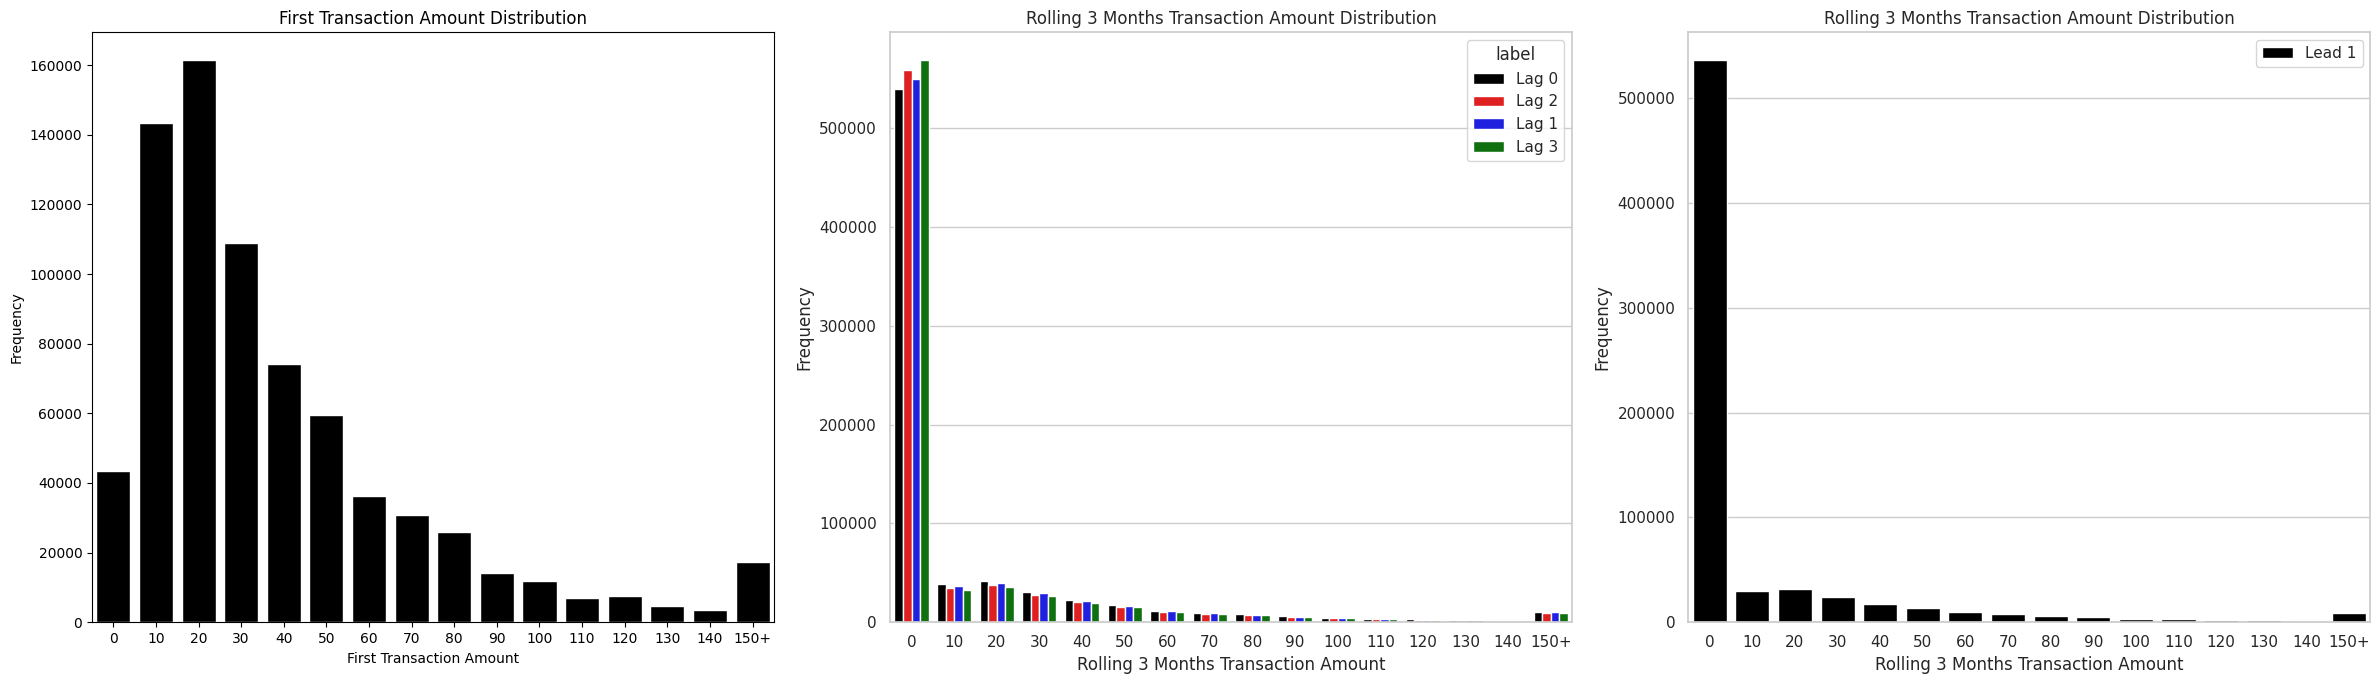

In [6]:
# Set the figure size
plt.figure(figsize=(24, 7))

###################################################################################
plt.subplot(131)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.first_trans_amt/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black"
)
plt.xlabel('First Transaction Amount')
plt.ylabel('Frequency')
plt.title('First Transaction Amount Distribution')

###################################################################################
plt.subplot(132)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag0.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag1.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag2.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_amt_R03m_lag3.values, columns=['trans_amt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:[np.floor(value/10)*10 if value >= 0 else -1 for value in x.trans_amt_R03m])
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

###################################################################################
plt.subplot(133)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl[pd.to_datetime(cltv_tbl.ref_dt) <= cutoff]
        .assign(bin = lambda x:np.floor(x.trans_amt_R03m_lead1/10)*10)
        .assign(bin = lambda x:[int(value) if value < 150 else 150 for value in x.bin])
        .assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin', 'bin_label'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin_label",
    y="counter",
    color="black",
    label="Lead 1"
)
plt.xlabel('Rolling 3 Months Transaction Amount')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Amount Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

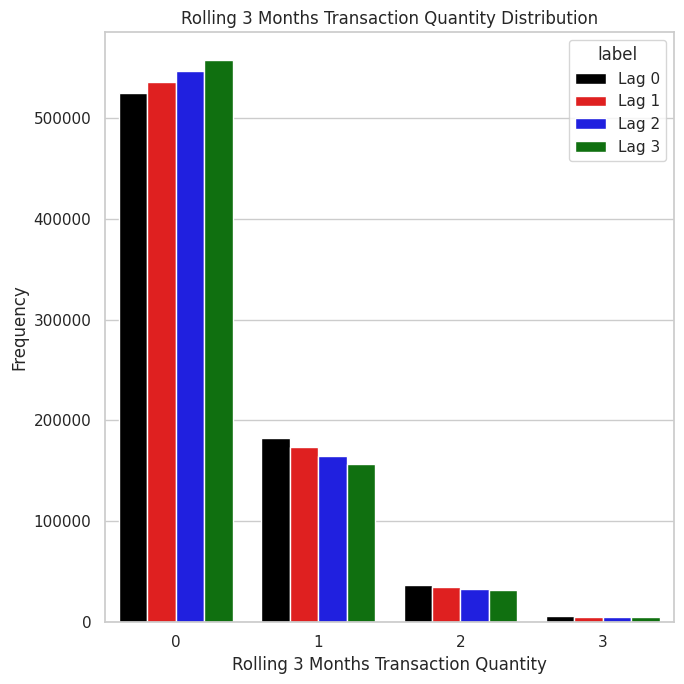

In [7]:
# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        pd.concat(
            [
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag0.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 0"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag1.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 1"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag2.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 2"),
              pd.DataFrame(cltv_tbl.trans_qnt_R03m_lag3.values, columns=['trans_qnt_R03m']).assign(label = lambda x: "Lag 3"),
            ], axis=0
        )
        .assign(bin = lambda x:x.trans_qnt_R03m)
        .assign(counter = lambda x:1)
        .groupby(['label', 'bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    hue="label",
    palette=["black", "red", "blue", "green"]
)
plt.xlabel('Rolling 3 Months Transaction Quantity')
plt.ylabel('Frequency')
plt.title('Rolling 3 Months Transaction Quantity Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

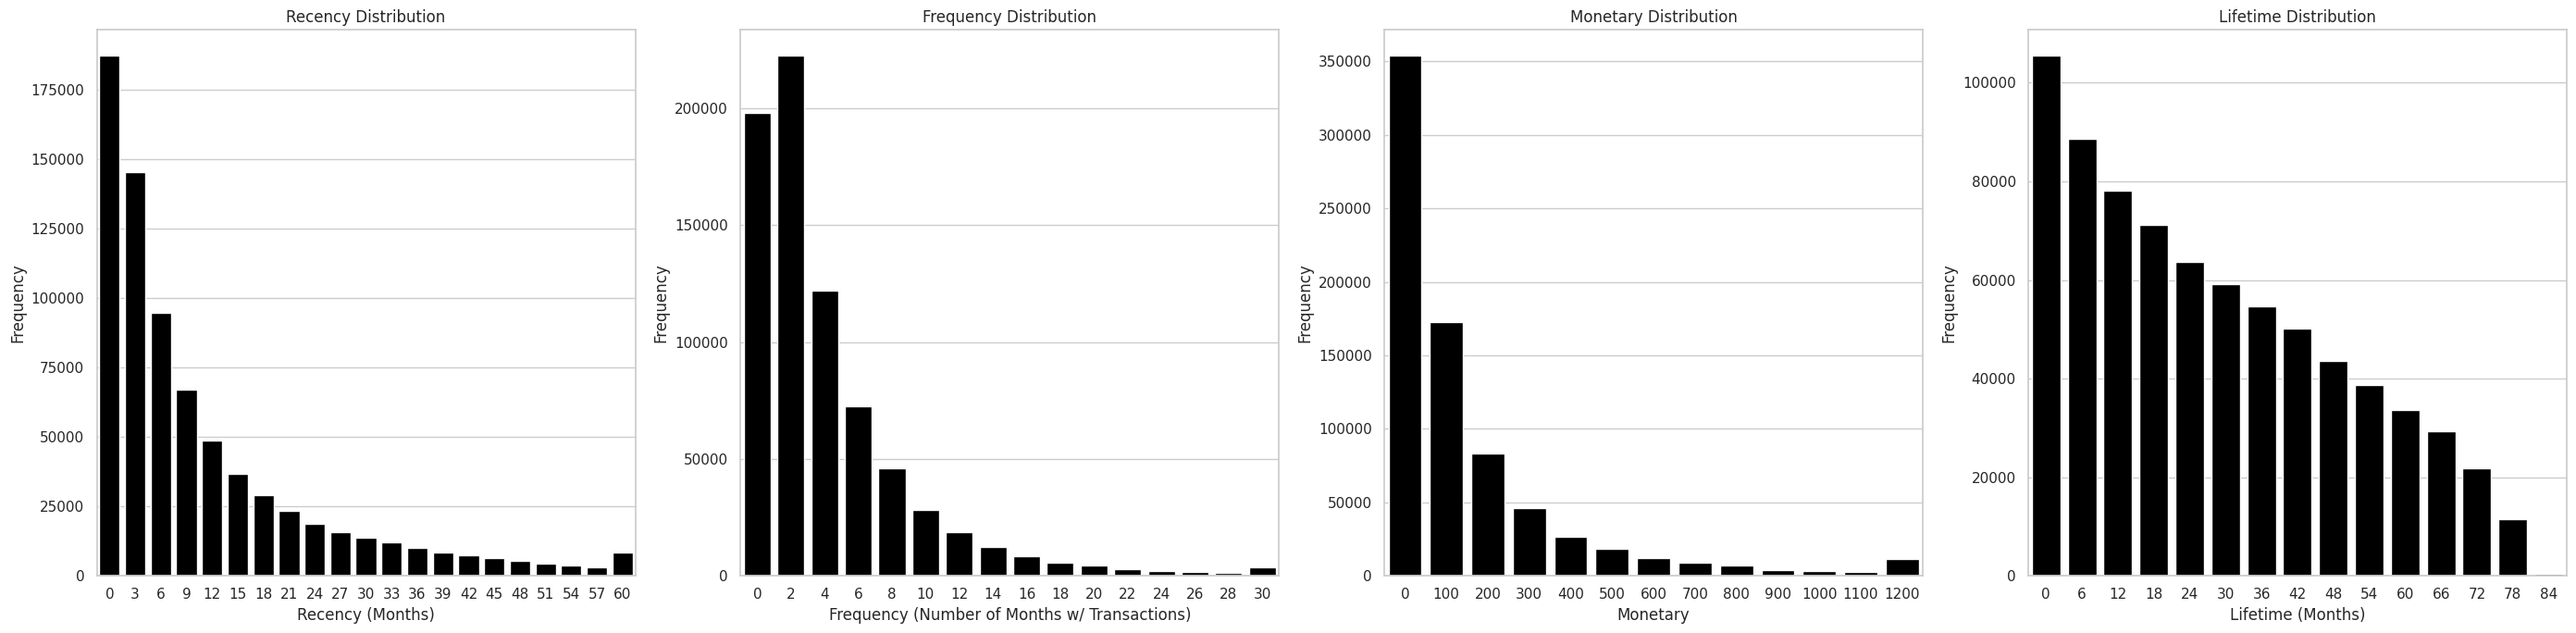

In [36]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(141)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.recency/3)*3)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Recency (Months)')
plt.ylabel('Frequency')
plt.title('Recency Distribution')

###################################################################################
plt.subplot(142)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.frequency/2)*2)
        .assign(bin = lambda x:[int(value) if value < 30 else 30 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Frequency (Number of Months w/ Transactions)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

###################################################################################
plt.subplot(143)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.monetary/100)*100)
        .assign(bin = lambda x:[int(value) if value < 1200 else 1200 for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Monetary Distribution')


###################################################################################
plt.subplot(144)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.lifetime/6)*6)
        .assign(bin = lambda x:[int(value) if value < 84 else 84 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Lifetime Distribution')


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

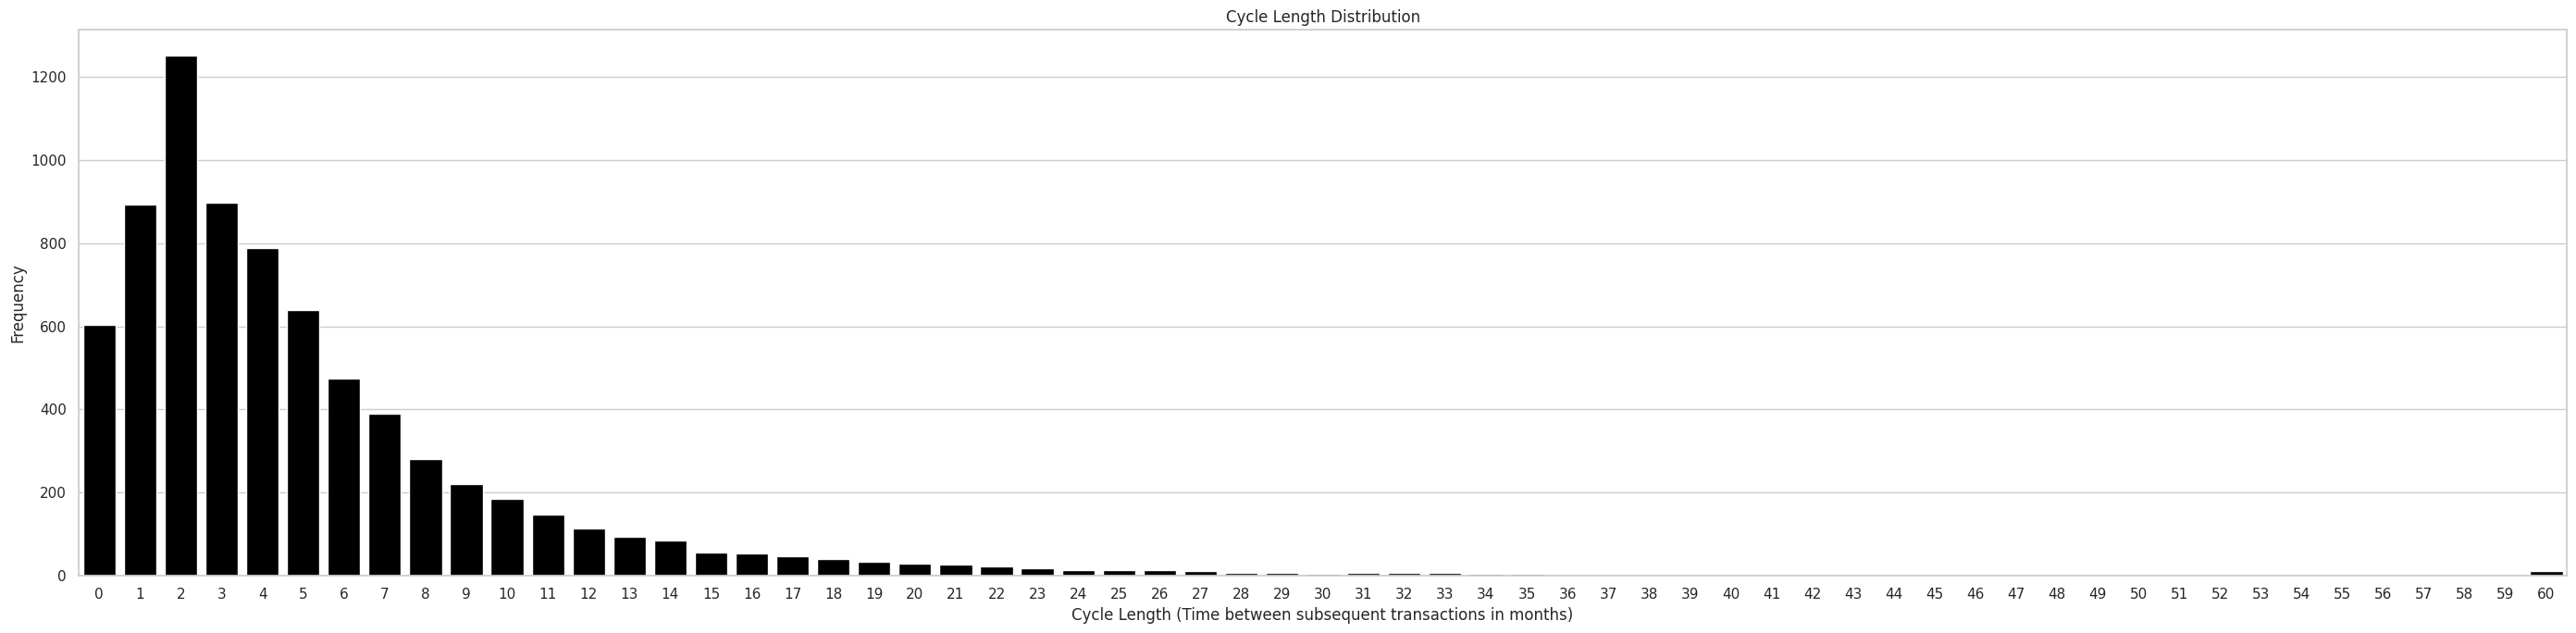

In [45]:
# Set the figure size
plt.figure(figsize=(28, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.barplot(
    data=(
        cltv_tbl
        .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
        .assign(bin = lambda x:[int(value) if value < 60 else 60 for value in x.bin])
        #.assign(bin_label = lambda x:[str(value) if value < 150 else '150+' for value in x.bin])
        .assign(counter = lambda x:1)
        .groupby(['bin'])
        .agg({'counter':'sum'})
        .reset_index()
        .sort_values(by="bin")
    ),
    x="bin",
    y="counter",
    color="black"
)
plt.xlabel('Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Frequency')
plt.title('Cycle Length Distribution')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

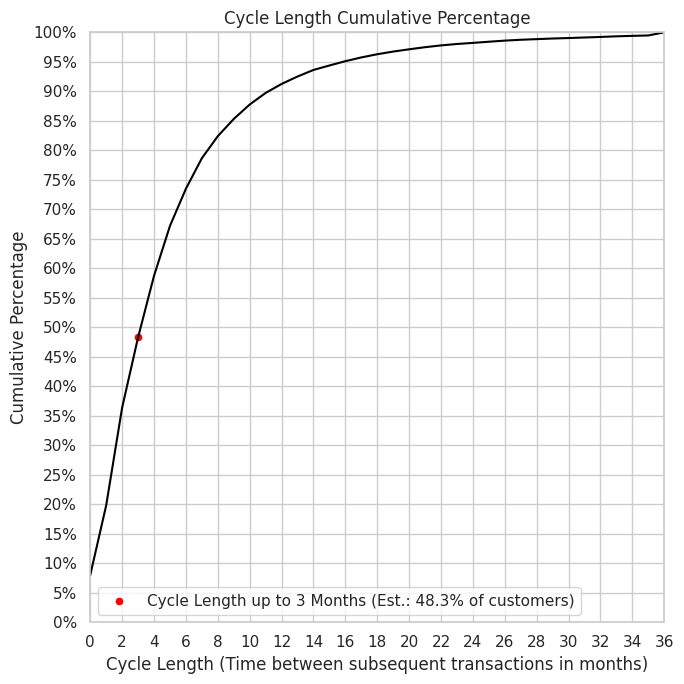

In [58]:
# Creating a dataframe with aggregated statistics on cycle length
cycle_length_tbl = (
  cltv_tbl
  .assign(bin = lambda x:np.floor(x.cycle_length/1)*1)
  .assign(bin = lambda x:[int(value) if value < 36 else 36 for value in x.bin])
  .assign(counter = lambda x:1)
  .groupby(['bin'])
  .agg({'counter':'sum'})
  .reset_index()
  .sort_values(by="bin")
  .assign(cumulative_percentage = lambda x:x.counter.cumsum()/x.counter.sum())
)

# Calculating the percentage of customers that have a cycle length of 3 months
pctg_trans_3m = cycle_length_tbl[cycle_length_tbl.bin==3].cumulative_percentage.values[0]

# Set the figure size
plt.figure(figsize=(7, 7))

###################################################################################
plt.subplot(111)
sns.set(style="whitegrid")
sns.lineplot(data=cycle_length_tbl, x="bin", y="cumulative_percentage", color="black")
sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Cycle Length (Time between subsequent transactions in months)')
plt.ylabel('Cumulative Percentage')
plt.title('Cycle Length Cumulative Percentage')

plt.xlim([0, 36])
plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

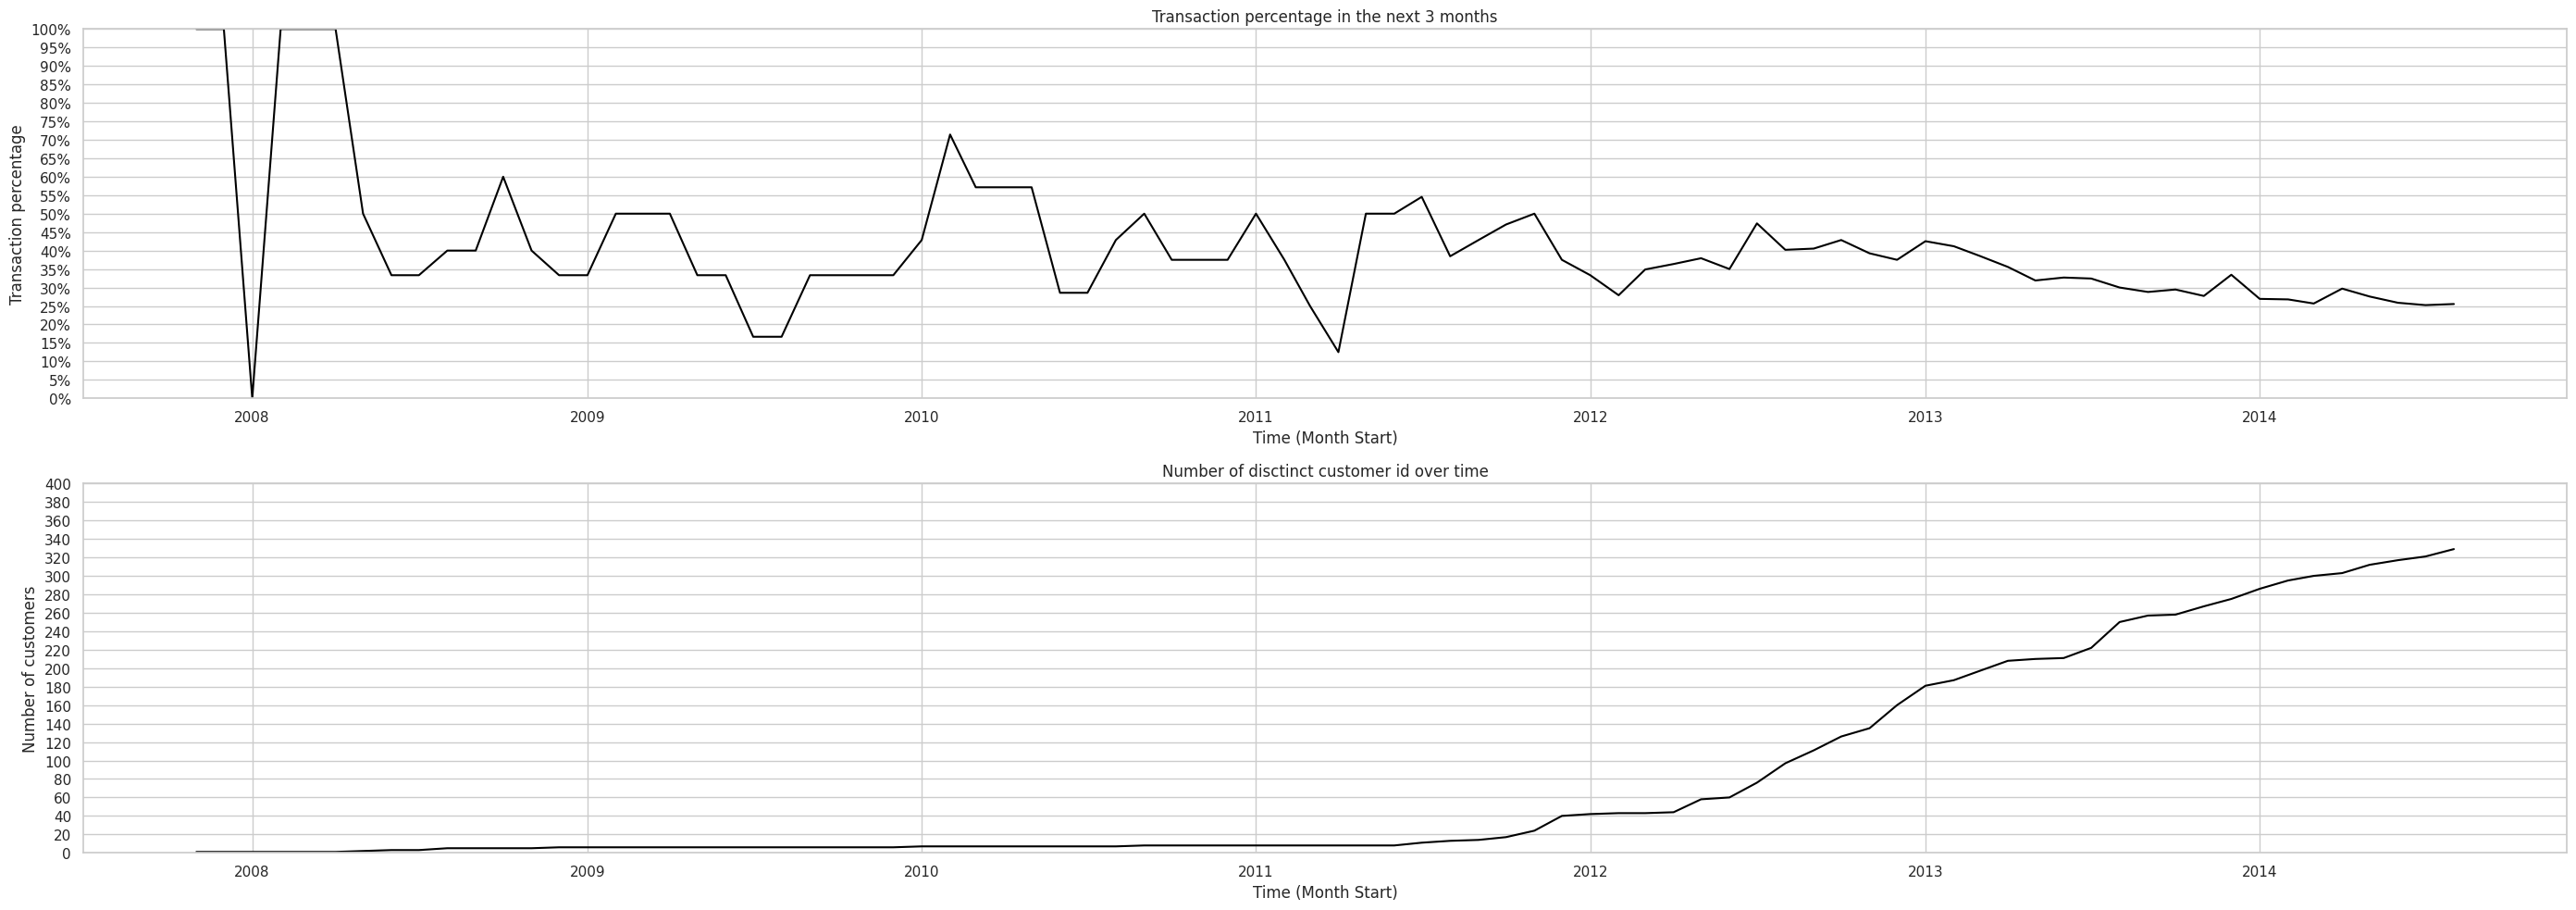

In [70]:
# Creating a transaction percentage in the next 3 months dataframe
trans_next_3m_tbl = (
    cltv_tbl[pd.to_datetime(cltv_tbl.ref_dt) <= cutoff]
    .assign(trans_next_3m = lambda x:np.where(x.trans_amt_R03m_lead1 > 0, 1, 0))
    .groupby(['ref_dt'])
    .agg({"trans_next_3m":"mean", "cust_id": lambda x: x.nunique()})
    .reset_index()
    .sort_values(by="ref_dt", ascending=True)

)


# Set the figure size
plt.figure(figsize=(28, 10))

###################################################################################
plt.subplot(211)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="trans_next_3m", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)')
plt.ylabel('Transaction percentage')
plt.title('Transaction percentage in the next 3 months')

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(212)
sns.set(style="whitegrid")
sns.lineplot(data=trans_next_3m_tbl, x="ref_dt", y="cust_id", color="black")
#sns.scatterplot(x=[3], y=[pctg_trans_3m], color="red", label=f"Cycle Length up to 3 Months (Est.: {np.round(100*pctg_trans_3m,1)}% of customers)")
plt.xlabel('Time (Month Start)')
plt.ylabel('Number of customers')
plt.title('Number of disctinct customer id over time')

plt.ylim([0, 400])
plt.yticks(ticks=[0 + i*20 for i in range(21)])


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

## Feature Adjustments

In [ ]:
cltv_tbl.trans_amt_R06m_lag1

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
            ...    
749984    -1.000000
749985    -1.000000
749986    -1.000000
749987    41.649981
749988    41.649981
Name: trans_amt_R06m_lag1, Length: 749989, dtype: float64

In [ ]:
cltv_train_adj_tbl = (

  cltv_train_tbl

  # Calculating the log of the first_trans_amt
  .assign(first_trans_amt = lambda x:np.log(x.first_trans_amt + 1))

  # Calculating the log of the recency
  .assign(recency = lambda x:np.log(x.recency + 1))

  # Calculating the log of the frequency
  .assign(frequency = lambda x:np.log(x.frequency + 1))

  # Calculating the log of the monetary
  .assign(monetary = lambda x:np.log(x.monetary + 1))

  # Calculating the log of the lifetime
  .assign(lifetime = lambda x:np.log(x.lifetime + 1))

  # Calculating the log of the trans_amt_R06m
  .assign(trans_amt_R06m = lambda x:np.log(x.trans_amt_R06m + 2))

  # Calculating the log of the trans_amt_R06m_lag1
  .assign(trans_amt_R06m_lag1 = lambda x:np.log(x.trans_amt_R06m_lag1 + 2))

  # Calculating the log of the trans_amt_R06m_lag2
  .assign(trans_amt_R06m_lag2 = lambda x:np.log(x.trans_amt_R06m_lag2 + 2))

  # Calculating the log of the trans_amt_R06m_mov_avg
  .assign(trans_amt_R06m_mov_avg = lambda x:np.log(x.trans_amt_R06m_mov_avg + 2))

)

cltv_train_adj_tbl.describe()

,first_trans_amt,trans_rate,recency,frequency,monetary,lifetime,trans_qnt_R06m,trans_qnt_R06m_lag1,trans_qnt_R06m_lag2,trans_qnt_R06m_mov_avg,trans_amt_R06m,trans_amt_R06m_lag1,trans_amt_R06m_lag2,trans_amt_R06m_mov_avg,logtarg
count,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000,248515.000000
mean,3.479225,0.013220,5.345639,1.481493,4.686535,6.389504,0.720287,0.658938,0.450464,0.925421,2.180934,2.132085,1.875566,3.340441,0.263912
std,0.729695,0.067244,1.150575,0.681869,1.134085,1.214080,0.958172,1.167142,1.238246,0.630182,1.667077,1.775298,1.819460,0.875942,0.947162
min,1.081805,0.000390,0.000000,0.693147,1.081805,0.000000,0.000000,-1.000000,-1.000000,0.070588,0.693147,0.000000,0.000000,0.896553,0.000000
25%,3.039749,0.002769,4.521789,0.693147,3.897752,5.862210,0.000000,0.000000,0.000000,0.467532,0.693147,0.693147,0.693147,2.737628,0.000000
50%,3.449942,0.005006,5.384495,1.386294,4.695889,6.708694,0.000000,0.000000,0.000000,0.827586,0.693147,0.693147,0.693147,3.319716,0.000000
75%,3.951270,0.009083,6.206576,1.945910,5.468874,7.266129,1.000000,1.000000,1.000000,1.164179,3.731770,3.777838,3.630024,3.925601,0.000000
max,8.621286,2.000000,7.852439,4.094345,8.672128,7.850298,6.000000,7.000000,7.000000,5.543478,8.672299,8.672299,8.672299,8.638699,5.508171


In [ ]:
# Listing features
features = [
  'first_trans_amt',
  'trans_rate',
  'recency',
  'frequency',
  'monetary',
  'lifetime',
  'trans_qnt_R06m',
  'trans_qnt_R06m_lag1',
  'trans_qnt_R06m_lag2',
  'trans_qnt_R06m_mov_avg',
  'trans_amt_R06m',
  'trans_amt_R06m_lag1',
  'trans_amt_R06m_lag2',
  'trans_amt_R06m_mov_avg'
]

# Calculating correlations
cltv_train_adj_tbl[['logtarg'] + features].corr()

,logtarg,first_trans_amt,trans_rate,recency,frequency,monetary,lifetime,trans_qnt_R06m,trans_qnt_R06m_lag1,trans_qnt_R06m_lag2,trans_qnt_R06m_mov_avg,trans_amt_R06m,trans_amt_R06m_lag1,trans_amt_R06m_lag2,trans_amt_R06m_mov_avg
logtarg,1.000000,0.021768,0.012216,-0.121924,0.137641,0.120510,0.005074,0.156739,0.129229,0.100940,0.170652,0.133416,0.111941,0.089267,0.130477
first_trans_amt,0.021768,1.000000,-0.002864,0.036303,-0.008618,0.444121,0.019576,-0.008208,0.000448,0.006344,0.000494,0.088993,0.090504,0.082776,0.520650
trans_rate,0.012216,-0.002864,1.000000,-0.354937,-0.091655,-0.087874,-0.445297,0.088933,-0.120350,-0.111170,0.081623,0.130780,-0.100032,-0.097930,0.068558
recency,-0.121924,0.036303,-0.354937,1.000000,-0.192846,-0.134004,0.550193,-0.703259,-0.193928,-0.024134,-0.573455,-0.763826,-0.273294,-0.083104,-0.483234
frequency,0.137641,-0.008618,-0.091655,-0.192846,1.000000,0.822918,0.557469,0.358094,0.532463,0.618385,0.568810,0.262120,0.426968,0.530700,0.453791
monetary,0.120510,0.444121,-0.087874,-0.134004,0.822918,1.000000,0.490470,0.291983,0.444183,0.515554,0.455198,0.295699,0.431310,0.504839,0.730831
lifetime,0.005074,0.019576,-0.445297,0.550193,0.557469,0.490470,1.000000,-0.211118,0.279834,0.456710,-0.188356,-0.314945,0.159404,0.356224,-0.163811
trans_qnt_R06m,0.156739,-0.008208,0.088933,-0.703259,0.358094,0.291983,-0.211118,1.000000,0.342941,0.152342,0.680100,0.860384,0.294275,0.128858,0.467827
trans_qnt_R06m_lag1,0.129229,0.000448,-0.120350,-0.193928,0.532463,0.444183,0.279834,0.342941,1.000000,0.469914,0.588514,0.215050,0.870845,0.411595,0.392185
trans_qnt_R06m_lag2,0.100940,0.006344,-0.111170,-0.024134,0.618385,0.515554,0.456710,0.152342,0.469914,1.000000,0.375972,0.055723,0.327041,0.893190,0.252645


## Target Variable Distribution

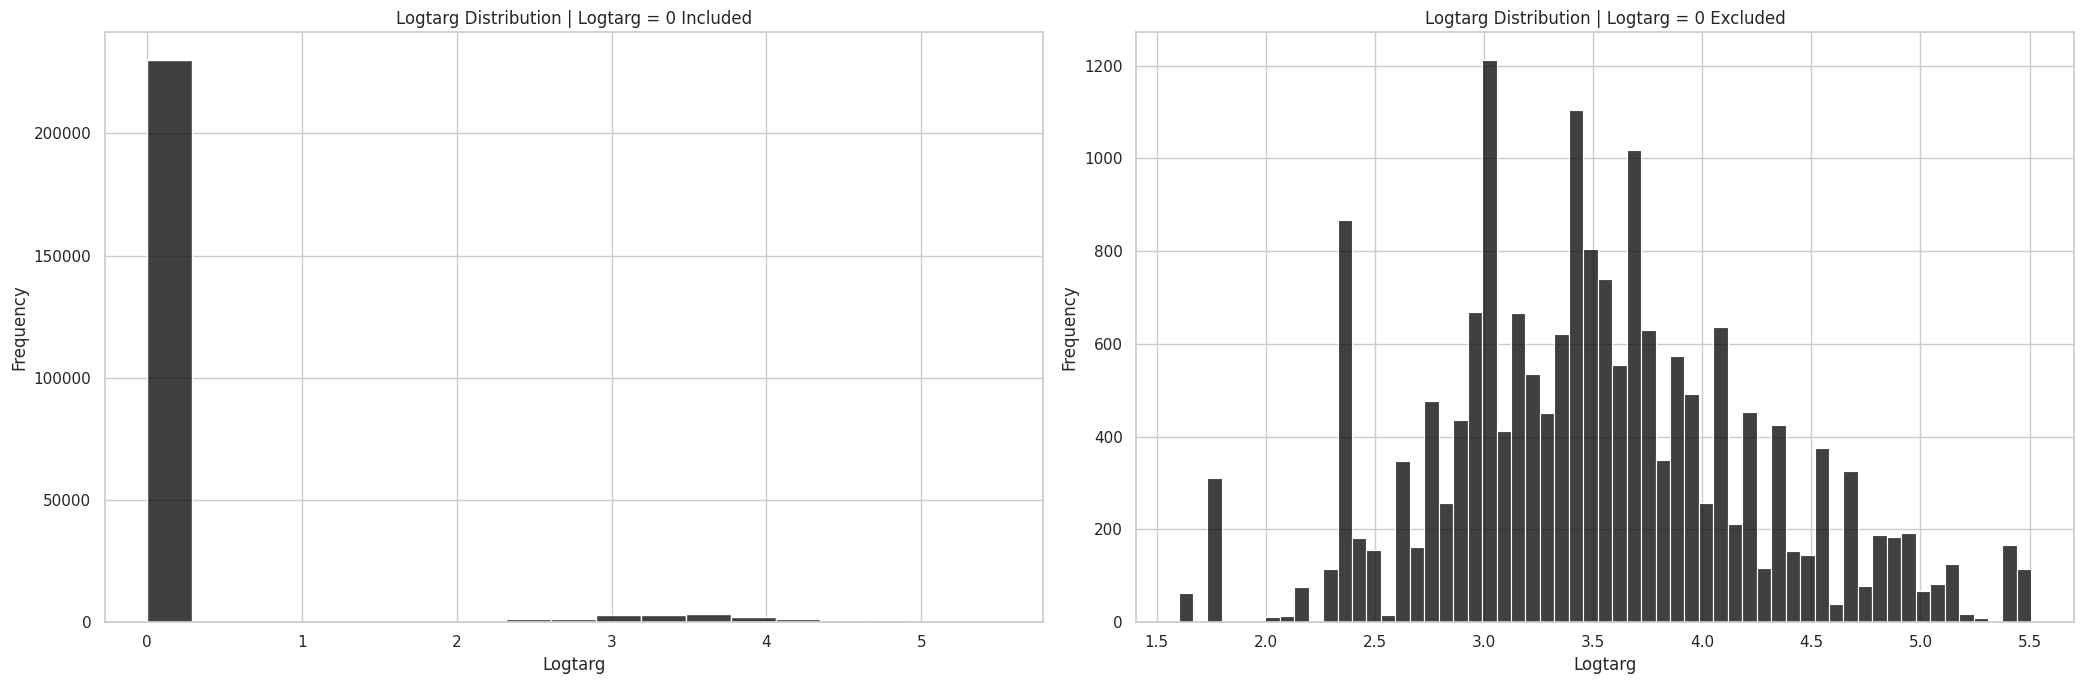

In [ ]:
# Creating the first CDF plot
plt.figure(figsize=(21, 7))  # Set the figure size

###################################################################################
plt.subplot(121)  # Create a subplot on the left
sns.set(style="whitegrid")
sns.histplot(data=cltv_train_tbl, x="logtarg", color="black")
plt.xlabel('Logtarg')
plt.ylabel('Frequency')
plt.title('Logtarg Distribution | Logtarg = 0 Included')

###################################################################################
plt.subplot(122)  # Create a subplot on the left
sns.set(style="whitegrid")
sns.histplot(data=cltv_train_tbl[cltv_train_tbl.logtarg > 0], x="logtarg", color="black")
plt.xlabel('Logtarg')
plt.ylabel('Frequency')
plt.title('Logtarg Distribution | Logtarg = 0 Excluded')

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

In [ ]:
# Calculating the number of records
cltv_train_adj_tbl

,cust_id,ref_dt,first_trans_amt,trans_rate,recency,frequency,monetary,lifetime,trans_qnt_R06m,trans_qnt_R06m_lag1,trans_qnt_R06m_lag2,trans_qnt_R06m_mov_avg,trans_amt_R06m,trans_amt_R06m_lag1,trans_amt_R06m_lag2,trans_amt_R06m_mov_avg,train,logtarg
0,4467051,2007-12-01,4.447812,0.074074,3.332205,0.693147,4.447812,2.674149,1,-1,-1,1.000000,4.459449,0.000000,0.0,4.459449,1,0.0
1,4467051,2008-01-01,4.447812,0.023256,4.077537,0.693147,4.447812,3.784190,1,-1,-1,1.000000,4.459449,0.000000,0.0,4.459449,1,0.0
2,4467051,2008-02-01,4.447812,0.013699,4.477337,0.693147,4.447812,4.304065,1,-1,-1,1.000000,4.459449,0.000000,0.0,4.459449,1,0.0
3,4467051,2008-03-01,4.447812,0.009709,4.779123,0.693147,4.447812,4.644391,1,-1,-1,1.000000,4.459449,0.000000,0.0,4.459449,1,0.0
4,4467051,2008-04-01,4.447812,0.007491,5.003946,0.693147,4.447812,4.901564,1,-1,-1,1.000000,4.459449,0.000000,0.0,4.459449,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248510,14755718,2013-11-01,3.041661,0.024540,4.043051,1.098612,3.659450,4.412798,2,-1,-1,1.500000,3.684871,0.000000,0.0,3.430432,1,0.0
248511,14755718,2013-12-01,3.041661,0.026786,4.143135,1.386294,4.409011,4.727388,3,-1,-1,1.800000,4.421104,0.000000,0.0,3.722063,1,0.0
248512,14755718,2014-01-01,3.041661,0.027972,3.332205,1.609438,4.804743,4.969813,4,1,-1,2.166667,4.812900,3.088311,0.0,4.006837,1,0.0
248513,14755718,2014-02-01,3.041661,0.028986,3.465736,1.791759,5.087831,5.156178,4,1,-1,2.428571,4.963530,3.088311,0.0,4.213046,1,0.0


In [ ]:
# Calculating the number of records
n_records = cltv_train_adj_tbl.shape[0]

# Listing train samples
train_samples = np.random.choice(a=np.arange(start=0, stop=n_records, step=1), size=int(n_records*0.8), replace=False)

In [ ]:
# Train set
X_tr = cltv_train_adj_tbl[cltv_train_adj_tbl.index.isin(train_samples)][features].values
y_tr = cltv_train_adj_tbl[cltv_train_adj_tbl.index.isin(train_samples)][['logtarg']].values.reshape(-1,1)

# Validation set
X_valid = cltv_train_adj_tbl[~cltv_train_adj_tbl.index.isin(train_samples)][features].values
y_valid = cltv_train_adj_tbl[~cltv_train_adj_tbl.index.isin(train_samples)][['logtarg']].values.reshape(-1,1)

In [ ]:
## Defining cost function: Zero-Inflated Mean Squared Error (ZIMSE)
##############################################################################################################
def zero_inflated_mean_squared_error_loss(y_true:tf.Tensor, y_pred:tf.Tensor) -> tf.Tensor:
  """Computes the zero-inflated mean squared error loss.

  Note: In order to really leverage the capabilities of the Zero-Inflated Mean Squared Error model make sure
  that the customer lifetime value labels are as close as possible to a normal distribution. In case it is not
  normally distributed, it is advisable to transaform the feature using the function y = np.log(x + 1).
  In case the previous transformation is implemented, you may want to apply the following inverse transformation
  to restore customer lifetime values: x = np.exp(y). It is not necessary to remove the unit ("-1") in the inverse
  function. The model itself is capable of abstracting this constant during training.

  Usage with tf.keras API:

  ```python
  model = tf.keras.Model(inputs, outputs)
  model.compile('Adam', loss=zero_inflated_mean_squared_error_loss)
  ```

  Arguments:
    y_true [tf.Tensor]: True targets, tensor of shape [batch_size, 1].
    y_pred [tf.Tensor]: Tensor of output layer, tensor of shape [batch_size, 2].

  Returns:
    Zero-inflated mean squared error loss value.
  """

  ## Creating a tensor from y_true.
  # This will a tensor with shape (m, 1), where "m" is the number of samples
  tf_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

  ## Creating a tensor from y_pred.
  # This will a tensor with shape (m, n), where "m" is the number of samples and "n" is the number of outputs.
  # Output 1: probability of transaction (calculated from sigmoid activation function)
  # Output 2: Customer Lifetime Value (calculated from linear activation function)
  tf_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  ## Calculating true labels.
  # This is necessary for the classification part of the cost function:
  # We want to distinguish CLV greater than 0 from CLV equal to zero.
  true_labels = tf.cast(tf_true > 0, tf.float32)

  ## Calculating predicted labels.
  # Transaction probabilities correspond to the first output of the y_pred tensor.
  pred_labels = tf_pred[..., :1]

  ## Classification loss
  # In order to calculate the classification loss we use Binary Cross-Entropy
  classification_loss = tf.keras.losses.binary_crossentropy(true_labels, pred_labels, from_logits=False)
  classification_loss = tf.reshape(classification_loss, [-1]) # Reshapes into a vector (m,)

  ## Adapting Customer Lifetime Value vector
  #pred_clv = tf.math.multiply(true_labels, tf_pred[..., 1:2])
  pred_clv = tf_pred[..., 1:2]

  ## Regression loss
  # In order to calculate the regression loss we use Mean-Squared Error
  regression_loss = tf.math.square(tf_true - pred_clv)
  regression_loss = tf.reshape(regression_loss, [-1]) # Reshapes into a vector (m,)

  ## Total Loss
  # Finally the total loss will be the sum of the classification loss and the regression loss
  total_loss = classification_loss + regression_loss

  return total_loss

In [ ]:
## Defining model: Zero-Inflated Mean Squared Error Model
##############################################################################################################
def zimse_model(input_shape:int, print_summary=False):
  """Creates a neural network model to be used with the zero-inflated mean squared error loss function.

  Note: In order to really leverage the capabilities of the Zero-Inflated Mean Squared Error model make sure
  that the customer lifetime value labels are as close as possible to a normal distribution. In case it is not
  normally distributed, it is advisable to transaform the feature using the function y = np.log(x + 1).
  In case the previous transformation is implemented, you may want to apply the following inverse transformation
  to restore customer lifetime values: x = np.exp(y). It is not necessary to remove the unit ("-1") in the inverse
  function. The model itself is capable of abstracting this constant during training.

  Usage with tf.keras API:

  ```python
  model.compile('Adam', loss=zero_inflated_mean_squared_error_loss)
  ```

  Arguments:
    input_shape [int]: An integer informing the number of features in the data.

  Returns:
    Model [keras.engine.functional.Functional]: TF Keras model (object containing the information for the entire training process using the zero-inflated mean squared error loss function).
  """

  # Defining input layer
  L0 = tf.keras.Input(shape=input_shape)

  # Defining Layer 1
  # Layer 1 has 64 neurons (unities) and a relu activation function
  L1 = tfl.Dense(units=64, activation="relu")(L0)

  # Defining Layer 2
  # Layer 2 has 32 neurons (unities) and a relu activation function
  L2 = tfl.Dense(units=32, activation="relu")(L1)

  # Defining Layer 3
  # Layer 3 has two neurons (unities) which one with a different activation function
  # The first activation function is a "sigmoid" function that is used to calculate the propensity score
  # The second activation functin is a "linear" function that is used to calculate customer lifetime value
  L3 = tfl.concatenate(
    [
      tfl.Dense(units=1, activation="sigmoid")(L2), # This neuron (unity) calculates the propensity score
      tfl.Dense(units=1, activation="relu")(L2) # This neuron (unity) calculates the customer lifetime value
    ]
  )

  # Defiing the zimse model
  # The zimse model has two outputs:
  # Output 1: propensity score (also interpreted as probability of churn)
  # Output 2: customer lifetime value
  model = tf.keras.Model(inputs=L0, outputs=L3)

  # check if it should print a summary of the model
  if print_summary:

    # summarize layers
    print(model.summary())

  return model

In [ ]:
# creating a zinmse clv model
model = zimse_model(input_shape=X_tr.shape[1])

In [ ]:
# Defining Optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Compiling the model
model.compile(loss=zero_inflated_mean_squared_error_loss, optimizer=optimizer)

In [ ]:
# Creating checkpoint
modelcheckpoint = ModelCheckpoint("../content/drive/MyDrive/Colab/Sandbox/weights_1024_1e4_500{epoch:03d}.hdf5", save_weights_only=True)

In [ ]:
# Training model
model.fit(X_tr, y_tr, batch_size=1024, epochs=500, verbose=1, validation_data=(X_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/500
195/195 [==============================] - 3s 6ms/step - loss: 1.2780 - val_loss: 1.2366
Epoch 2/500
195/195 [==============================] - 1s 4ms/step - loss: 1.2241 - val_loss: 1.2292
Epoch 3/500
195/195 [==============================] - 1s 5ms/step - loss: 1.2208 - val_loss: 1.2273
Epoch 4/500
195/195 [==============================] - 1s 4ms/step - loss: 1.2193 - val_loss: 1.2261
Epoch 5/500
195/195 [==============================] - 1s 5ms/step - loss: 1.2183 - val_loss: 1.2254
Epoch 6/500
195/195 [==============================] - 1s 6ms/step - loss: 1.2177 - val_loss: 1.2250
Epoch 7/500
195/195 [==============================] - 2s 9ms/step - loss: 1.2173 - val_loss: 1.2245
Epoch 8/500
195/195 [==============================] - 1s 8ms/step - loss: 1.2170 - val_loss: 1.2243
Epoch 9/500
195/195 [==============================] - 2s 8ms/step - loss: 1.2168 - val_loss: 1.2241
Epoch 10/500
195/195 [==============================] - 1s 4ms/step - loss: 1.2167 - val_lo

In [ ]:
# creating a zinmle clv model
model = zimse_model(input_shape=X_valid.shape[1])

# Total number of epochs
n = 500

# Initializing the results dictionary
results = {
  'zimse':{
    'epoch':list(range(1,n+1)),
    'loss':[],
    'auc':[],
    'spearmanr':[],
    'spearmanp':[],
    'pearsonr':[],
    'pearsonp':[],
    'rmse':[]
  }
}

# Calculating True Label
p_true = (y_valid > 0).astype(int).reshape(-1)

# Calculting True CLVs
mu_true = y_valid.astype(int).reshape(-1)

# Iterating through all epochs
for i in results['zimse']['epoch']:

  # Printing epoch being evaluated
  print(f"Evaluating epoch: {i}/{n}")

  # Loading weights
  model.load_weights(f"../content/drive/MyDrive/Colab/Sandbox/weights_1024_1e4_500{str(i).zfill(3)}.hdf5")

  # Making predictions
  y_pred = model.predict(X_valid)

  # Fetching probabilities
  p_pred = y_pred[:,0]

  # Fetching customer lifetime values
  mu_pred = y_pred[:,1]

  # Calculating AUC
  results['zimse']['auc'] += [roc_auc_score(p_true, p_pred)]

  # Calculating loss list
  loss = zero_inflated_mean_squared_error_loss(y_true=y_valid.reshape(-1,1), y_pred=y_pred)
  results['zimse']['loss'] += [np.mean(loss.numpy())]

  # Calculating Spearman correlation coefficient and p-value
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]

  # Calculating Pearson correlation coefficient and p-value
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]

  # Calculating RMSE
  results['zimse']['rmse'] += [np.mean((mu_true - mu_pred)**2)**0.5]



Evaluating epoch: 1/500
1554/1554 [==============================] - 4s 2ms/step


<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


Evaluating epoch: 2/500
1554/1554 [==============================] - 2s 1ms/step


<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


Evaluating epoch: 3/500
1554/1554 [==============================] - 2s 2ms/step


<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


Evaluating epoch: 4/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 5/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 6/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 7/500
1554/1554 [==============================] - 2s 2ms/step
Evaluating epoch: 8/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 9/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 10/500
1554/1554 [==============================] - 5s 3ms/step
Evaluating epoch: 11/500
1554/1554 [==============================] - 4s 3ms/step
Evaluating epoch: 12/500
1554/1554 [==============================] - 2s 2ms/step
Evaluating epoch: 13/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 14/500
  36/1554 [..............................] - ETA: 2s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 15/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 16/500
  77/1554 [>.............................] - ETA: 1s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 17/500
  25/1554 [..............................] - ETA: 3s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 4s 2ms/step
Evaluating epoch: 18/500
  67/1554 [>.............................] - ETA: 2s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 4s 2ms/step
Evaluating epoch: 19/500
  74/1554 [>.............................] - ETA: 2s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 2ms/step
Evaluating epoch: 20/500
  20/1554 [..............................] - ETA: 4s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 4s 2ms/step
Evaluating epoch: 21/500
  22/1554 [..............................] - ETA: 3s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 22/500
  73/1554 [>.............................] - ETA: 2s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 23/500
  37/1554 [..............................] - ETA: 2s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 2ms/step
Evaluating epoch: 24/500
   1/1554 [..............................] - ETA: 49s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 4s 2ms/step
Evaluating epoch: 25/500
  40/1554 [..............................] - ETA: 1s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 26/500
  75/1554 [>.............................] - ETA: 2s

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 27/500
  38/1554 [..............................] - ETA: 2s 

<ipython-input-188-73e9f02b03aa>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanr'] += [stats.spearmanr(mu_true, mu_pred).correlation]
<ipython-input-188-73e9f02b03aa>:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['spearmanp'] += [stats.spearmanr(mu_true, mu_pred).pvalue]
<ipython-input-188-73e9f02b03aa>:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonr'] += [stats.pearsonr(mu_true, mu_pred)[0]]
<ipython-input-188-73e9f02b03aa>:58: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results['zimse']['pearsonp'] += [stats.pearsonr(mu_true, mu_pred)[1]]


1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 28/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 29/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 30/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 31/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 32/500
1554/1554 [==============================] - 6s 4ms/step
Evaluating epoch: 33/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 34/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 35/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 36/500
1554/1554 [==============================] - 2s 1ms/step
Evaluating epoch: 37/500
1554/1554 [==============================] - 3s 2ms/step
Evaluating epoch: 38/500
1554/1554 [==============================] - 6s 4ms/step
Evaluating epoch: 39/500
1554/1554 [=====

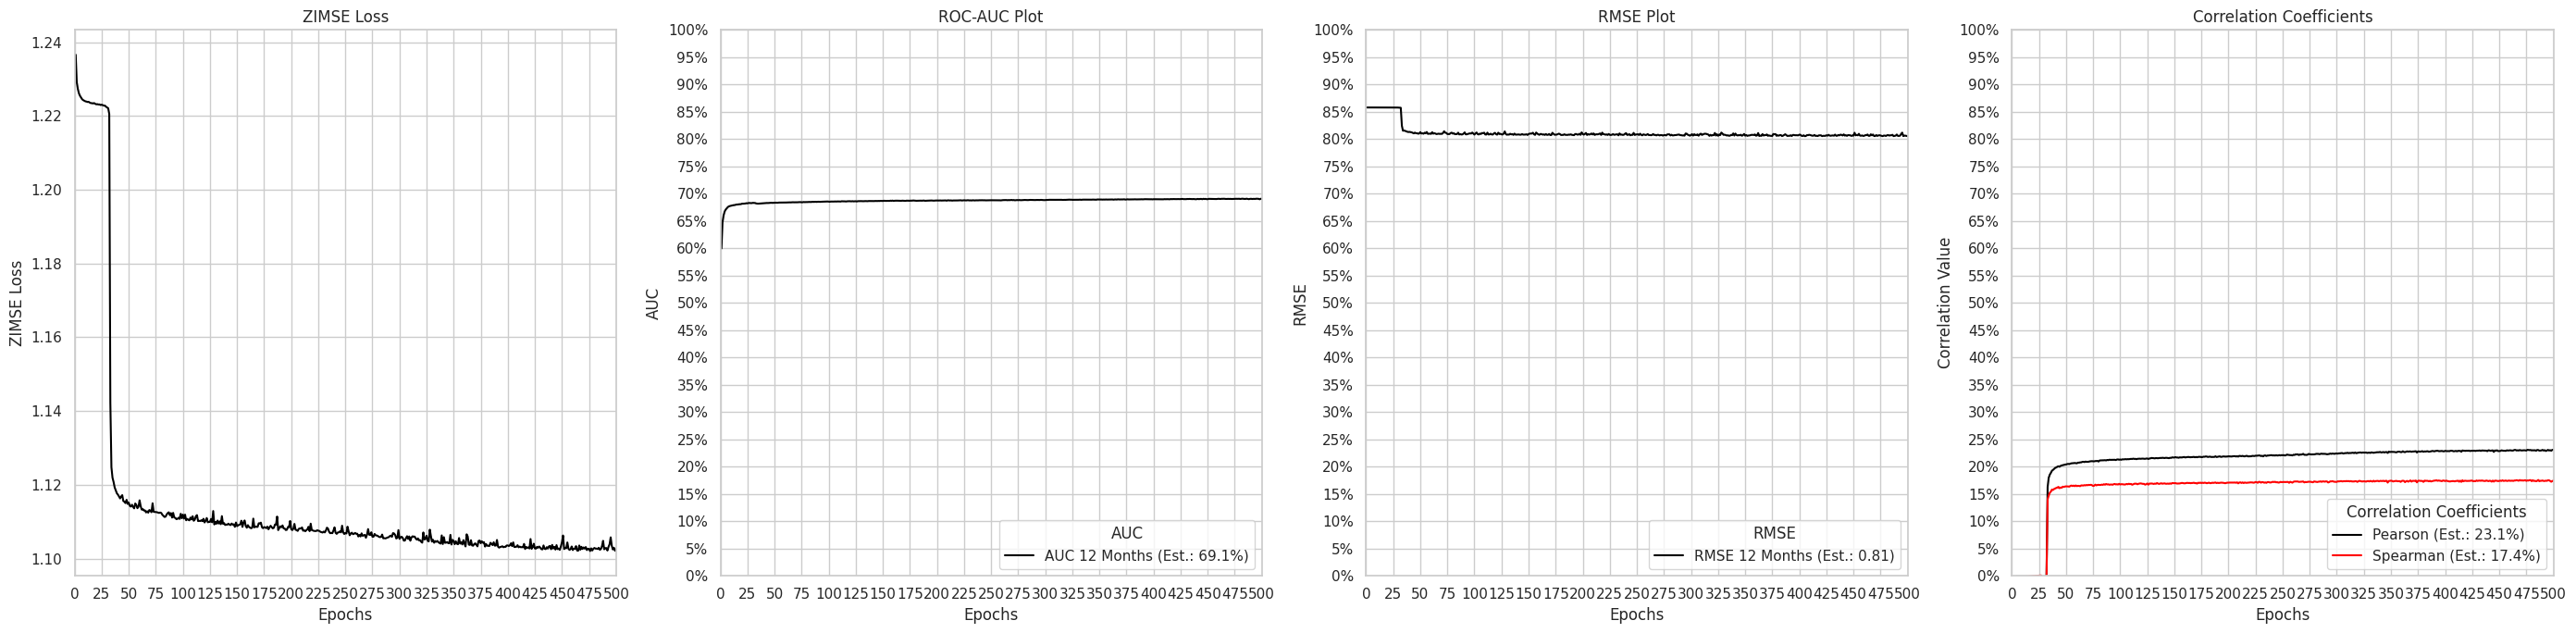

In [ ]:
# Creating the first CDF plot
plt.figure(figsize=(28, 7))  # Set the figure size

###################################################################################
plt.subplot(141)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['zimse']['epoch'], y=results['zimse']['loss'], color="black")
#sns.lineplot(x=X_pred_2[:,0], y=y_pred_2[:,0], color="red", label=f"Average P(No Purchase): {np.round(100*p_churn,2)}%")
#plt.legend(loc='upper right', ncol=1, title=u"Sub-Categories")
plt.xlabel('Epochs')
plt.ylabel('ZIMSE Loss')
plt.title('ZIMSE Loss')

plt.xlim([0, 500])
plt.xticks(ticks=[0 + i*25 for i in range(21)])

###################################################################################
plt.subplot(142)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['zimse']['epoch'], y=results['zimse']['auc'], color="black", label=f"AUC 12 Months (Est.: {np.round(100*results['zimse']['auc'][-1],1)}%)")
plt.legend(loc='lower right', ncol=1, title=u"AUC")
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('ROC-AUC Plot')

plt.xlim([0, 500])
plt.xticks(ticks=[0 + i*25 for i in range(21)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(143)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['zimse']['epoch'], y=results['zimse']['rmse'], color="black", label=f"RMSE 12 Months (Est.: {np.round(results['zimse']['rmse'][-1],2)})")
plt.legend(loc='lower right', ncol=1, title=u"RMSE")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE Plot')

plt.xlim([0, 500])
plt.xticks(ticks=[0 + i*25 for i in range(21)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(144)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['zimse']['epoch'], y=results['zimse']['pearsonr'], color="black", label=f"Pearson (Est.: {np.round(100*results['zimse']['pearsonr'][-1],1)}%)")
sns.lineplot(x=results['zimse']['epoch'], y=results['zimse']['spearmanr'], color="red", label=f"Spearman (Est.: {np.round(100*results['zimse']['spearmanr'][-1],1)}%)")
plt.legend(loc='lower right', ncol=1, title=u"Correlation Coefficients")
plt.xlabel('Epochs')
plt.ylabel("Correlation Value")
plt.title('Correlation Coefficients')

plt.xlim([0, 500])
plt.xticks(ticks=[0 + i*25 for i in range(21)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

In [ ]:
# Definining an optimization function
def objective_function(params):

  # Defining model
  lgb_rg = lgb.LGBMRegressor(
    boosting_type=params["boosting_type"],
    learning_rate=float(params["learning_rate"]),
    n_estimators=int(params["n_estimators"]),
    objective=params["objective"],
    num_leaves=int(params["num_leaves"]),
    subsample=float(params["subsample"]/100),
    colsample_bytree=float(params['colsample_bytree']/100),
    reg_alpha=float(params['reg_alpha']/100),
    reg_lambda=float(params['reg_lambda']/100),
    verbose=-1
  ).fit(X_tr, y_tr.reshape(-1))

  # Making predictions
  y_pred = lgb_rg.predict(X_valid)

  # Calculating RMSE
  lgbm_rmse = np.sqrt(np.mean((y_valid.reshape(-1) - y_pred)**2))

  return lgbm_rmse

# Defining a search space
search_space = {
  "boosting_type": hp.choice(label="boosting_type", options=['gbdt']),
  "learning_rate": hp.choice(label="learning_rate", options=[0.1, 0.01, 0.001, 0.0001]),
  "n_estimators": hp.choice(label="n_estimators", options=[500, 1000, 1500, 2000]),
  "objective": hp.choice(label="objective", options=['mean_squared_error']),
  "num_leaves": hp.quniform("num_leaves", low=2, high=70, q=1),
  "subsample": hp.quniform(label="subsample", low=10, high=100, q=1),
  "colsample_bytree": hp.quniform(label="colsample_bytree", low=10, high=100, q=1),
  "reg_alpha": hp.quniform(label="reg_alpha", low=2, high=100, q=1),
  "reg_lambda": hp.quniform(label="reg_lambda", low=2, high=100, q=1)
}

# Defining a trials object
trials = Trials()

# Finding best parameters
best_hyperparam = fmin(
  fn=objective_function,
  space=search_space,
  algo=tpe.suggest,
  max_evals=100,
  trials=trials
)

100%|██████████| 100/100 [46:08<00:00, 27.69s/trial, best loss: 0.530229847419125]


In [ ]:
best_hyperparam

{'boosting_type': 0,
 'colsample_bytree': 91.0,
 'learning_rate': 0,
 'n_estimators': 3,
 'num_leaves': 69.0,
 'objective': 0,
 'reg_alpha': 76.0,
 'reg_lambda': 57.0,
 'subsample': 95.0}

In [ ]:
# Definining an optimization function
def objective_function(params):

  # Defining model
  lgb_cf = lgb.LGBMClassifier(
    boosting_type=params["boosting_type"],
    learning_rate=float(params["learning_rate"]),
    n_estimators=int(params["n_estimators"]),
    objective=params["objective"],
    num_leaves=int(params["num_leaves"]),
    subsample=float(params["subsample"]/100),
    colsample_bytree=float(params['colsample_bytree']/100),
    reg_alpha=float(params['reg_alpha']/100),
    reg_lambda=float(params['reg_lambda']/100),
    verbose=-1
  ).fit(X_tr, (y_tr.reshape(-1) > 0).astype(int))

  # Making predictions
  y_pred = lgb_cf.predict(X_valid)

  # Calculating AUC
  lgbm_auc = roc_auc_score((y_valid.reshape(-1) > 0).astype(int), lgb_cf.predict_proba(X_valid)[:,1])

  return -lgbm_auc

# Defining a search space
search_space = {
  "boosting_type": hp.choice(label="boosting_type", options=['gbdt']),
  "learning_rate": hp.choice(label="learning_rate", options=[0.1, 0.01, 0.001, 0.0001]),
  "n_estimators": hp.choice(label="n_estimators", options=[500, 1000, 1500, 2000]),
  "objective": hp.choice(label="objective", options=['cross_entropy']),
  "num_leaves": hp.quniform("num_leaves", low=2, high=70, q=1),
  "subsample": hp.quniform(label="subsample", low=10, high=100, q=1),
  "colsample_bytree": hp.quniform(label="colsample_bytree", low=10, high=100, q=1),
  "reg_alpha": hp.quniform(label="reg_alpha", low=2, high=100, q=1),
  "reg_lambda": hp.quniform(label="reg_lambda", low=2, high=100, q=1)
}

# Defining a trials object
trials = Trials()

# Finding best parameters
best_hyperparam = fmin(
  fn=objective_function,
  space=search_space,
  algo=tpe.suggest,
  max_evals=100,
  trials=trials
)

100%|██████████| 100/100 [1:03:27<00:00, 38.07s/trial, best loss: -0.983564120066032]


In [ ]:
best_hyperparam

NameError: name 'best_hyperparam' is not defined